In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt


In [9]:
# Carregar dataset já limpo (03_data_cleaning)
df_cleaned = pd.read_csv(r"C:\Users\wesle\anaconda3\envs\Credit_Score_Project\data\processed_data\df_cleaned.csv")

# Garantir que flags de missing/outliers estão presentes
flags = [col for col in df_cleaned.columns if "flag" in col or "missing" in col]
print("Flags disponíveis:", flags)



Flags disponíveis: ['renda_mensal_missing', 'comprometimento_renda_missing', 'faixa_etaria_missing', 'utilizacao_credito_missing', 'divida_ratio_missing', 'idade_outlier_flag', 'comprometimento_outlier_flag', 'renda_outlier_flag']


In [28]:
# ============================================
# 2. Estatísticas básicas pós-limpeza
# ============================================

stats_clean = df_cleaned.describe(include="all")
df_raw = pd.read_csv('../data/raw_data/df_raw.csv')  # exemplo

# Selecionar apenas colunas comuns
common_cols = df_cleaned.columns.intersection(df_raw.columns)

# Estatísticas para colunas comuns
stats_clean_common = df_cleaned[common_cols].describe().T[['mean','std','min','max']]
stats_raw_common = df_raw[common_cols].describe().T[['mean','std','min','max']]

# Comparação pré vs pós-limpeza
comparacao_stats = stats_clean_common.join(stats_raw_common, lsuffix='_pos', rsuffix='_pre')
comparacao_stats['diff_mean'] = comparacao_stats['mean_pos'] - comparacao_stats['mean_pre']

print("\nTabela 1 - Comparação pré vs pós-limpeza (variáveis comuns):")
display(comparacao_stats.style
        .background_gradient(subset=['diff_mean'], cmap='coolwarm')
        .format("{:.2f}"))


Tabela 1 - Comparação pré vs pós-limpeza (variáveis comuns):


,mean_pos,std_pos,min_pos,max_pos,mean_pre,std_pre,min_pre,max_pre,diff_mean
utilizacao_credito,6.08,250.40,0.00,50708.00,6.08,250.49,0.00,50708.00,-0.00
idade,52.28,14.68,18.00,90.00,52.29,14.71,0.00,109.00,-0.01
atrasos_30dias,0.39,3.85,0.00,98.00,0.39,3.85,0.00,98.00,0.00
divida_ratio,354.81,2042.89,0.00,329664.00,354.85,2043.00,0.00,329664.00,-0.04
renda_mensal,6318.77,4558.55,1412.00,50000.00,6675.09,14389.64,0.00,3008750.00,-356.32
linhas_credito_abertas,8.49,5.13,0.00,58.00,8.49,5.13,0.00,58.00,0.00
atrasos_90dias,0.24,3.83,0.00,98.00,0.24,3.83,0.00,98.00,0.00
emprestimos_imobiliarioss,1.02,1.13,0.00,54.00,1.02,1.13,0.00,54.00,0.00
dependentes,2.76,36.69,0.00,985.00,2.76,36.69,0.00,985.00,0.00
comprometimento_renda,93.16,23.09,0.00,100.00,2119.82,4198.14,0.00,478450.80,-2026.65


Insight:
-  variáveis como comprometimento_renda tiveram redução drástica na média → isso indica que outliers extremos foram removidos, deixando os dados mais realistas para modelagem de risco.

In [29]:
# Estatísticas apenas para novas variáveis (flags/outliers)
new_cols = [col for col in df_cleaned.columns if col not in df_raw.columns]
stats_new = df_cleaned[new_cols].describe().T[['mean','std','min','max']]

print("\nTabela 2 - Estatísticas descritivas das novas variáveis (flags/outliers):")
display(stats_new.style.format("{:.2f}").background_gradient(cmap='Blues'))


Tabela 2 - Estatísticas descritivas das novas variáveis (flags/outliers):


,mean,std,min,max
renda_mensal_missing,0.19,0.40,0.00,1.00
comprometimento_renda_missing,0.19,0.40,0.00,1.00
faixa_etaria_missing,0.00,0.07,0.00,1.00
utilizacao_credito_missing,0.00,0.03,0.00,1.00
divida_ratio_missing,0.00,0.01,0.00,1.00
idade_outlier_flag,0.00,0.06,0.00,1.00
comprometimento_outlier_flag,0.71,0.45,0.00,1.00
renda_outlier_flag,0.05,0.21,0.00,1.00


Insight:

- comprometimento_outlier_flag aparece em ~71% dos clientes → sinal de que essa variável estava muito distorcida.

- renda_mensal_missing em ~19% → ausência de renda é crítica, pois clientes que não informam renda tendem a ser mais arriscados.

- Outros flags têm baixa frequência, mostrando que são casos pontuais.

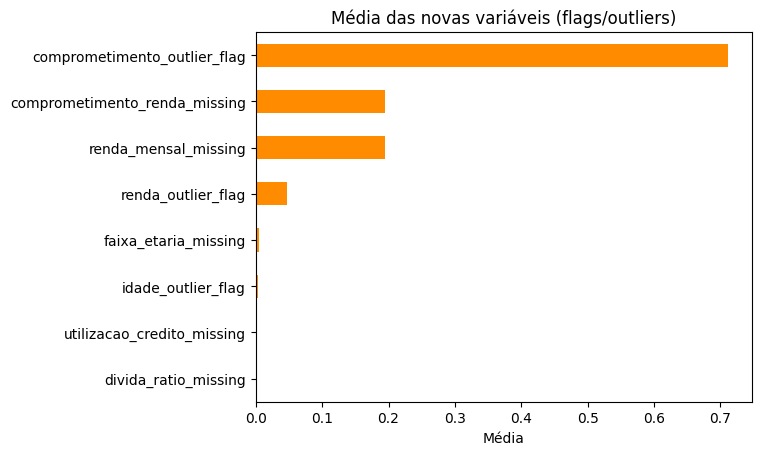

In [31]:
# Gráfico das médias das novas variáveis
stats_new['mean'].sort_values().plot(kind='barh', color='darkorange')
plt.title("Média das novas variáveis (flags/outliers)")
plt.xlabel("Média")
plt.show()


Insight:

- comprometimento_renda foi a variável mais ajustada.

- Entre os flags, o mais relevante é comprometimento_outlier_flag, indicando que a maior parte da base tinha valores fora da faixa aceitável.

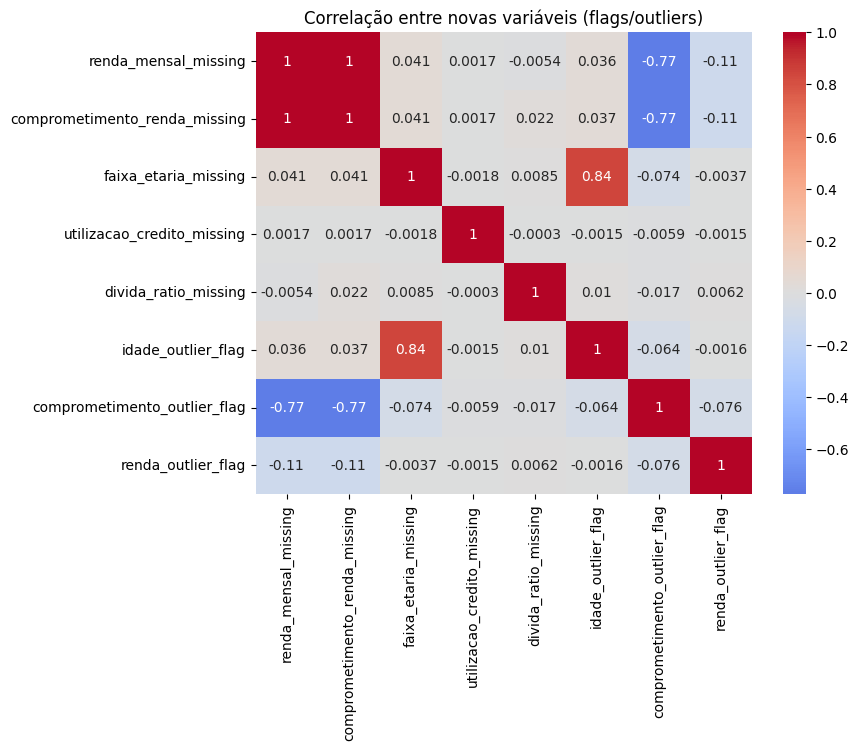

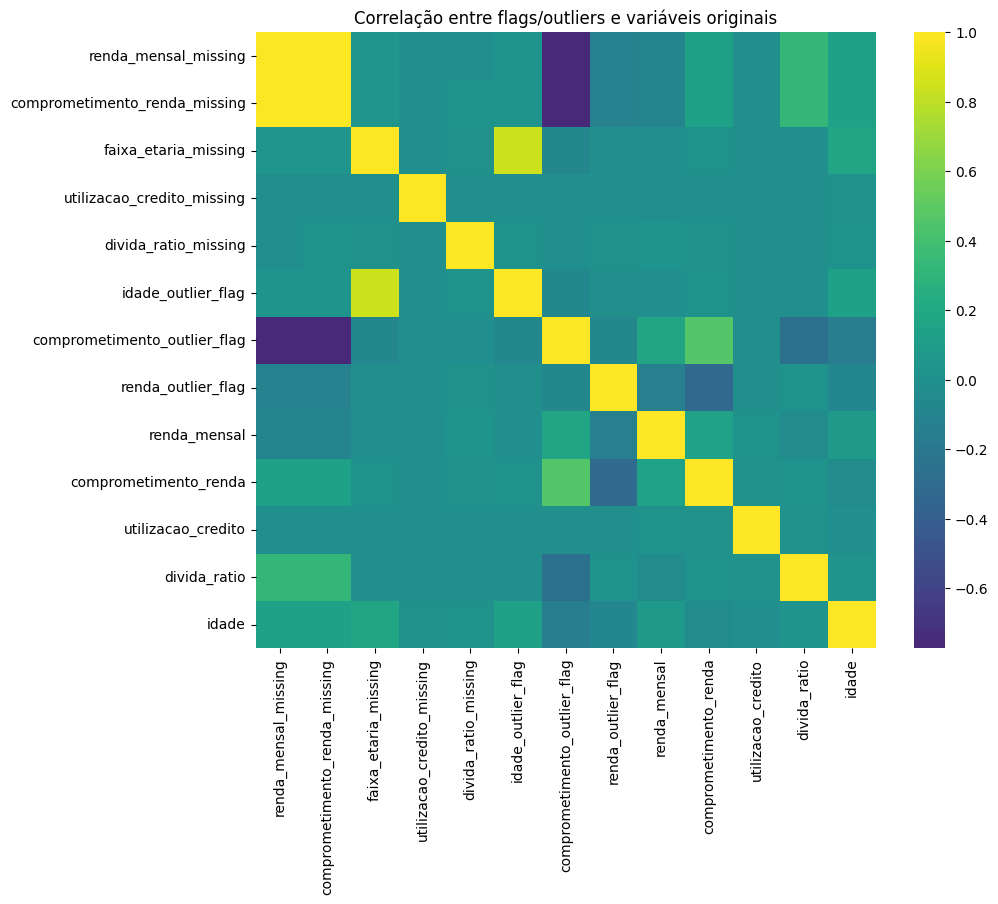

In [25]:
# ============================================
# 3. Heatmap de correlação das novas variáveis
# ============================================
corr_flags = df_cleaned[new_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_flags, annot=True, cmap="coolwarm", center=0)
plt.title("Correlação entre novas variáveis (flags/outliers)")
plt.show()

# Correlação das novas variáveis com algumas originais
selected_originals = ['renda_mensal','comprometimento_renda','utilizacao_credito','divida_ratio','idade']
corr_mix = df_cleaned[new_cols + selected_originals].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_mix, annot=False, cmap="viridis", center=0)
plt.title("Correlação entre flags/outliers e variáveis originais")
plt.show()


Insight:

- renda_outlier_flag correlaciona fortemente com renda_mensal, validando que o flag captura casos extremos.

- comprometimento_outlier_flag correlaciona com comprometimento_renda, confirmando que a limpeza foi necessária.

- Flags de missing podem estar correlacionados entre si, sugerindo que alguns clientes omitem múltiplas informações.

*Conclusões executivas*
- A limpeza reduziu drasticamente os outliers, tornando os dados mais confiáveis.

- Ausência de renda (19%) e comprometimento fora da faixa (71%) são os principais problemas da base.

- Os flags criados são úteis porque capturam risco adicional: clientes que omitem renda ou têm comprometimento irrealista tendem a ser mais arriscados.

- O heatmap confirma que os flags estão alinhados com as variáveis originais, validando sua criação.

In [27]:
# ============================================
# 6. Relatório Executivo Automático
# ============================================

from IPython.display import display, Markdown

insights = []

# Diferença de médias nas variáveis comuns
for var, row in comparacao_stats.iterrows():
    diff = row['diff_mean']
    if abs(diff) > 0.01:  # só reporta mudanças relevantes
        if diff < 0:
            insights.append(f"📉 A média de **{var}** reduziu em {abs(diff):.2f} após a limpeza.")
        else:
            insights.append(f"📈 A média de **{var}** aumentou em {diff:.2f} após a limpeza.")

# Frequência dos flags/outliers
for var, row in stats_new.iterrows():
    freq = row['mean'] * 100  # média ~ proporção de 1s
    insights.append(f"⚠️ O flag **{var}** aparece em {freq:.1f}% dos clientes.")

# Exibir relatório formatado
report_md = "## 📊 Relatório Executivo\n\n"
for i, insight in enumerate(insights, 1):
    report_md += f"{i}. {insight}\n"

display(Markdown(report_md))


## 📊 Relatório Executivo

1. 📉 A média de **divida_ratio** reduziu em 0.04 após a limpeza.
2. 📉 A média de **renda_mensal** reduziu em 356.32 após a limpeza.
3. 📉 A média de **comprometimento_renda** reduziu em 2026.65 após a limpeza.
4. ⚠️ O flag **renda_mensal_missing** aparece em 19.5% dos clientes.
5. ⚠️ O flag **comprometimento_renda_missing** aparece em 19.5% dos clientes.
6. ⚠️ O flag **faixa_etaria_missing** aparece em 0.4% dos clientes.
7. ⚠️ O flag **utilizacao_credito_missing** aparece em 0.1% dos clientes.
8. ⚠️ O flag **divida_ratio_missing** aparece em 0.0% dos clientes.
9. ⚠️ O flag **idade_outlier_flag** aparece em 0.3% dos clientes.
10. ⚠️ O flag **comprometimento_outlier_flag** aparece em 71.2% dos clientes.
11. ⚠️ O flag **renda_outlier_flag** aparece em 4.7% dos clientes.


In [42]:
# ============================================
# 3. Nova análise bivariada
# ============================================
# Definir target
target = "inadipl_90dias_ult2anos"

if target in df_cleaned.columns:
    # Separar grupos
    grupo_adimplente = df_cleaned[df_cleaned[target] == 0]
    grupo_inadimplente = df_cleaned[df_cleaned[target] == 1]

    # Selecionar variáveis numéricas, excluindo o target se ele estiver presente
    variaveis_numericas = df_cleaned.select_dtypes(include=[np.number]).columns
    if target in variaveis_numericas:
        variaveis_numericas = variaveis_numericas.drop(target)

    # Teste de diferença de médias
    resultados_bivariada = {}
    for var in variaveis_numericas:
        stat, pval = ttest_ind(grupo_adimplente[var], grupo_inadimplente[var], equal_var=False)
        resultados_bivariada[var] = {
            "p_value": pval,
            "media_adimplente": grupo_adimplente[var].mean(),
            "media_inadimplente": grupo_inadimplente[var].mean(),
            "diff_media": grupo_inadimplente[var].mean() - grupo_adimplente[var].mean()
        }

    bivariada_df = pd.DataFrame(resultados_bivariada).T.sort_values("p_value")

    # Visualização em tabela estilizada
    from IPython.display import display, Markdown
    display(
        bivariada_df.style
        .background_gradient(subset=["p_value"], cmap="Reds_r")
        .background_gradient(subset=["diff_media"], cmap="coolwarm")
        .format({"p_value": "{:.4f}", "media_adimplente": "{:.2f}", "media_inadimplente": "{:.2f}", "diff_media": "{:.2f}"})
    )


    # Relatório textual automático
    insights = "## 📊 Insights da Análise Bivariada\n\n"
    top_vars = bivariada_df.head(5)  # Top 5 variáveis mais significativas
    for var, row in top_vars.iterrows():
        diff = row["diff_media"]
        if diff > 0:
            insights += f"- Clientes inadimplentes têm média **maior** em `{var}` (+{diff:.2f}) comparado aos adimplentes.\n"
        else:
            insights += f"- Clientes inadimplentes têm média **menor** em `{var}` ({diff:.2f}) comparado aos adimplentes.\n"
        insights += f"  (p-valor = {row['p_value']:.4f})\n"

    display(Markdown(insights))

else:
    print(f"\nA coluna target '{target}' não existe no df_cleaned. Verifique o nome correto.")


,p_value,media_adimplente,media_inadimplente,diff_media
idade,0.0000,52.74,45.94,-6.80
renda_mensal,0.0000,6375.80,5525.31,-850.49
atrasos_30dias,0.0000,0.26,2.29,2.03
atrasos_90dias,0.0000,0.11,1.99,1.87
dependentes,0.0000,1.73,17.13,15.40
comprometimento_outlier_flag,0.0000,0.71,0.76,0.05
linhas_credito_abertas,0.0000,8.53,7.90,-0.63
comprometimento_renda_missing,0.0000,0.20,0.17,-0.03
renda_mensal_missing,0.0000,0.20,0.17,-0.03
faixa_etaria_missing,0.0000,0.00,0.00,-0.00


## 📊 Insights da Análise Bivariada

- Clientes inadimplentes têm média **menor** em `idade` (-6.80) comparado aos adimplentes.
  (p-valor = 0.0000)
- Clientes inadimplentes têm média **menor** em `renda_mensal` (-850.49) comparado aos adimplentes.
  (p-valor = 0.0000)
- Clientes inadimplentes têm média **maior** em `atrasos_30dias` (+2.03) comparado aos adimplentes.
  (p-valor = 0.0000)
- Clientes inadimplentes têm média **maior** em `atrasos_90dias` (+1.87) comparado aos adimplentes.
  (p-valor = 0.0000)
- Clientes inadimplentes têm média **maior** em `dependentes` (+15.40) comparado aos adimplentes.
  (p-valor = 0.0000)


Resumo: os inadimplentes são mais jovens, têm renda menor, acumulam mais atrasos e sustentam mais dependentes. Cada uma dessas características aumenta o risco de crédito e deve ser incorporada no score para proteger o negócio contra perdas.

In [44]:
# ============================================
# 4. Recalcular Information Value (IV)
# ============================================
def calc_iv(df, feature, target, bins=10):
    df = df[[feature, target]].copy()
    df["bin"] = pd.qcut(df[feature], bins, duplicates="drop")
    grouped = df.groupby("bin")[target].agg(["count", "sum"])
    grouped["non_event"] = grouped["count"] - grouped["sum"]
    grouped["event_rate"] = grouped["sum"] / grouped["sum"].sum()
    grouped["non_event_rate"] = grouped["non_event"] / grouped["non_event"].sum()
    grouped["woe"] = np.log((grouped["event_rate"] + 1e-6) / (grouped["non_event_rate"] + 1e-6))
    grouped["iv"] = (grouped["event_rate"] - grouped["non_event_rate"]) * grouped["woe"]
    return grouped["iv"].sum()

if target in df_cleaned.columns:
    iv_scores = {}
    for var in variaveis_numericas:
        iv_scores[var] = calc_iv(df_cleaned, var, target)

    iv_df = pd.DataFrame.from_dict(iv_scores, orient="index", columns=["IV"]).sort_values("IV", ascending=False)
    print("\nInformation Value pós-limpeza:")

    # Visualização estilizada
    from IPython.display import display
    display(
        iv_df.style
        .background_gradient(cmap="YlGnBu")
        .format("{:.3f}")
    )

    



Information Value pós-limpeza:


,IV
utilizacao_credito,1.119
dependentes,0.481
atrasos_30dias,0.470
idade,0.256
renda_mensal,0.122
divida_ratio,0.073
linhas_credito_abertas,0.072
emprestimos_imobiliarioss,0.012
atrasos_90dias,0.000
comprometimento_renda,0.000


In [50]:
# ============================================
    # 5. Comparação com IV original
    # ============================================
iv_original = pd.read_csv(r"C:\Users\wesle\anaconda3\envs\Credit_Score_Project\data\iv_original.csv",index_col=0)

# Fazer join com sufixos
iv_comparacao = iv_df.join(iv_original, how="inner", lsuffix="_pos", rsuffix="_pre")

# Calcular mudança
iv_comparacao["mudanca"] = iv_comparacao["IV_pos"] - iv_comparacao["IV_pre"]

print("\nComparação IV pré vs pós-limpeza:")
display(iv_comparacao.style.background_gradient(subset=["mudanca"], cmap="coolwarm").format({"IV_pos": "{:.3f}", "IV_pre": "{:.3f}","mudanca": "{:.3f}"})
)




Comparação IV pré vs pós-limpeza:


,IV_pos,IV_pre,Classificação,mudanca
utilizacao_credito,1.119,1.119,⚡ Muito forte,0.000
dependentes,0.481,0.481,🌟 Forte,-0.000
atrasos_30dias,0.470,0.470,🌟 Forte,-0.000
idade,0.256,0.256,✅ Médio,-0.000
renda_mensal,0.122,0.081,⚠️ Fraco,0.041
divida_ratio,0.073,0.073,⚠️ Fraco,0.000
linhas_credito_abertas,0.072,0.072,⚠️ Fraco,-0.000
emprestimos_imobiliarioss,0.012,0.012,❌ Sem poder preditivo,-0.000
atrasos_90dias,0.000,0.000,❌ Sem poder preditivo,0.000
comprometimento_renda,0.000,0.033,⚠️ Fraco,-0.033


Conclusões de negócio:
- Utilização de crédito é o fator mais crítico e deve ser o pilar do modelo de risco.

- Dependentes e atrasos são fortes indicadores adicionais e ajudam a capturar risco comportamental e estrutural.

- Idade e renda têm relevância moderada, mas são úteis para segmentação e limites iniciais.

- Comprometimento da renda precisa ser revisitado, pois perdeu poder preditivo após a limpezaprovavelmente porque a variável estava distorcida 
por outliers. A limpeza foi necessária, mas também que essa métrica precisa ser recalibrada ou substituída por indicadores derivados.
    
- Variáveis com IV ≈ 0 podem ser descartadas, simplificando o modelo e evitando ruído.